# __Dataset:__ Hospital Length of Stay

## Dataset Source
[Kaggle Hospital Length of Stay Dataset](https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft)

## Objective

* The goal of this analysis is to identify key factors that predict hospital length of stay for patients. 
* We use clinical measurements (laboratory tests, vital signs), body metrics, previous admissions, and hospital facility information as features. 

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

## Reading and Understanding Data

In [3]:
df = pd.read_csv("LengthOfStay.csv")
print("\nThe first 5 rows of the dataframe\n")
df.head()


The first 5 rows of the dataframe



,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


In [5]:
print("The dataset contain {:,} rows".format(df.shape[0]))
print("Number of Columns: {}".format(df.shape[1]))

The dataset contain 100,000 rows
Number of Columns: 28


### __Dataset Description__

<h3><center>1- Identifiers and Dates</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| eid |  Unique ID for Hospital Addmission | [1, 100,000] |
| vdate | Visit Date | 'mm/dd/yyyy' |
| discharged | Date of Discharge | 'mm/dd/yyyy' |
| facid | Facility ID at which the encounter occurred | ['A', 'B', ... , 'E']|

--------------------------------------------------------------------------------------------------------

<h3><center>2- Patient Demographics</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| gender | Gender of Patient | F, M |

--------------------------------------------------------------------------------------------------------

<h3><center>3- Utilization History</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| rcount | Number of readmissions within the last 180 days | '0', '1', ... , '5+' |

--------------------------------------------------------------------------------------------------------

<h3><center>4- Medical Conditions (binary flags)</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| dialysisrenalendstage | Flag for Renal Disease during encounter | [0, 1] |
| asthma | Flag for Asthma duing encounter | [0, 1] |
| irondef | Flag for Iron Deficiency during encounter | [0, 1] |
| pneum | Flag for Pneumonia during encounter | [0, 1] |
| substancedependence | Flag for Substance Dependence | [0, 1] |
| psychologicaldisordermajor | Flag for Major Psychological Disorder during encounter | [0, 1] |
| depress | Flag for Depression during encounter | [0, 1] |
| psychother | Flag for Other psychological disorder during encounter | [0, 1] |
| fibrosisandother | Flag for Fibrosis during encounter | [0, 1] |
| malnutrition | Flag for malnutrituion during encounter | [0, 1] |
| hemo | Flag for blood disorder during encounter | [0, 1] |
| secondarydiagnosisnonicd9 | Flag for whether a non ICD 9 formatted diagnosis was coded as a secondary diagnosis |[0, 10]|

--------------------------------------------------------------------------------------------------------

<h3><center>5- Medical Conditions (non-binary flags)</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| secondarydiagnosisnonicd9 | Number of Secondary diagnoses during encounter that was were coded using non-ICD-9 format |[0, 10]|

--------------------------------------------------------------------------------------------------------

<h3><center>6- Laboratory Measurements</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| hematocrit | Average hematocrit value during encounter (g/dL) | Float |
| neutrophils | Average neutrophils value during encounter (cells/microL) | Float |
| sodium | Average sodium value during encounter (mmol/L) | Float |
| glucose | Average blood glucose level during encounter (mmol/L) | Float |
| bloodureanitro | Average blood urea nitrogen value during encounter (mg/dL) | Float |
| creatinine | Average creatinine value during encounter (mg/dL) | Float |

--------------------------------------------------------------------------------------------------------

<h3><center>7- Vital Signs and Body Metrics</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| bmi | Average BMI during encounter (kg/m2) | Float |
| pulse |Average pulse during encounter (beats/m) | Integer |
| respiration | Average respiration during encounter (breaths/m) | Float |

--------------------------------------------------------------------------------------------------------

<h3><center>8- <strong>Target Variable:</strong> Length of Stay</center></h3>

| Data Field | Description | Example Values |
| :--------: | :---------: | :------------: |
| lengthofstay | Length of stay for the encounter | Integer |


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  object 
 3   gender                      100000 non-null  object 
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  int64  
 13  malnutrition   

According to the output above, we have 100,000 enteries as well as 28 features. The Non-Null Count column shows that we have no missing values in this dataset. We can confirm this by running the below code. 

In [9]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [11]:
df.dtypes.value_counts()

int64      15
float64     8
object      5
Name: count, dtype: int64

We have a mix of int64, float64 and object data types.

Let's get statistical information about all numeric values while excluding binary columns.

In [13]:
cols = [col for col in df.nunique().index[df.nunique() > 2] if df[col].dtype != 'object']
df[cols].describe()

,eid,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,50000.500000,11.975939,10.177455,137.891397,141.963384,14.097185,1.099350,29.805759,73.444720,6.493768,2.123310,4.00103
std,28867.657797,2.031792,5.353131,2.999669,29.992996,12.952454,0.200262,2.003769,11.644555,0.568473,2.050641,2.36031
min,1.000000,4.400000,0.100000,124.912632,-1.005927,1.000000,0.219770,21.992683,21.000000,0.200000,0.000000,1.00000
25%,25000.750000,10.900000,7.700000,135.871062,121.682383,11.000000,0.964720,28.454235,66.000000,6.500000,1.000000,2.00000
50%,50000.500000,11.900000,9.400000,137.887151,142.088545,12.000000,1.098764,29.807516,73.000000,6.500000,1.000000,4.00000
75%,75000.250000,12.900000,11.500000,139.912885,162.180996,14.000000,1.234867,31.156885,81.000000,6.500000,3.000000,6.00000
max,100000.000000,24.100000,245.900000,151.387283,271.444277,682.500000,2.035202,38.935293,130.000000,10.000000,10.000000,17.00000


## Data Cleaning and Wrangling

We have establised that we have no missing values in this dataset.

Let's check if we have duplicates.

In [17]:
print("The number of duplicated rows in this dataset is {}".format(df.duplicated().sum()))

The number of duplicated rows in this dataset is 0


We have two columns that represent dates (vdate, discharged)

In [19]:
df[['vdate', 'discharged']].dtypes

vdate         object
discharged    object
dtype: object

We can see they are recorded as object columns, let's change them to DatetimeIndex to be able to perform datetime arithmetic operations.

In [21]:
df['vdate'] = pd.to_datetime(df['vdate'])
df['discharged'] = pd.to_datetime(df['discharged'])

In [23]:
df.dtypes.value_counts()

int64             15
float64            8
object             3
datetime64[ns]     2
Name: count, dtype: int64

Now the number of object columns is reduced to 3.

Now let's check if the length of stay is equal to the difference recorded between the visit data and the discharged date.

In [25]:
((df['discharged'] - df['vdate']).dt.days == df['lengthofstay']).all()

True

Okay, we establish that there is a match.

Now let's check columns with object data type.

In [27]:
[col for col in df.columns if df[col].dtype == 'object']

['rcount', 'gender', 'facid']

In [29]:
df.rcount.unique()

array(['0', '5+', '1', '3', '4', '2'], dtype=object)

The recount column represent the number of hospital admissions within the last 180 days. It should be numeric, but we observe the 5+ value which means more than 5 times.

In [31]:
counts = df.rcount.value_counts()
percentages = df.rcount.value_counts(normalize=True)*100

pd.DataFrame({
    'Count': counts,
    'Percent%': percentages
})

,Count,Percent%
rcount,,
0,55031,55.031
1,15007,15.007
2,9987,9.987
3,8047,8.047
4,6941,6.941
5+,4987,4.987


The value 5+ represent less than 5% of all the values. We will change the values to numbers.

In [33]:
df['rcount'] = df['rcount'].replace('5+', 5).astype(int)

df.dtypes.value_counts()

int64             15
float64            8
datetime64[ns]     2
object             2
int32              1
Name: count, dtype: int64

## Feature Engineering

Let's add a feature to flag if the day is a weekend or weekday.

In [35]:
df['is_weekend'] = (df['vdate'].dt.weekday >= 5).astype('int')
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay,is_weekend
0,1,2012-08-29,0,F,0,0,0,0,0,0,...,12.0,1.390722,30.432418,96,6.5,4,2012-09-01,B,3,0
1,2,2012-05-26,5,F,0,0,0,0,0,0,...,8.0,0.943164,28.460516,61,6.5,1,2012-06-02,A,7,1
2,3,2012-09-22,1,F,0,0,0,0,0,0,...,12.0,1.065750,28.843812,64,6.5,2,2012-09-25,B,3,1
3,4,2012-08-09,0,F,0,0,0,0,0,0,...,12.0,0.906862,27.959007,76,6.5,1,2012-08-10,A,1,0
4,5,2012-12-20,0,F,0,0,0,1,0,1,...,11.5,1.242854,30.258927,67,5.6,2,2012-12-24,E,4,0


Let's drop columns that we will not be needing.

In [37]:
df = df.drop(['eid', 'vdate', 'discharged'], axis=1)

## Checking Normality Assumption

Let's check if the target variable is normally distributed. We will create function that plot histogram, boxplot and Q-Q plot.

In [39]:
def normality_diagnosis_plots(series, feature):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))

    sns.histplot(series, kde=True, ax=axes[0])
    axes[0].set_title(f"{feature} Histogram")

    stats.probplot(series, dist="norm", plot=axes[1])
    axes[1].set_title(f"{feature} Q-Q Plot")

    sns.boxplot(x=series, ax=axes[2])
    axes[2].set_title(f"{feature} Boxplot")

    plt.tight_layout()
    plt.show()

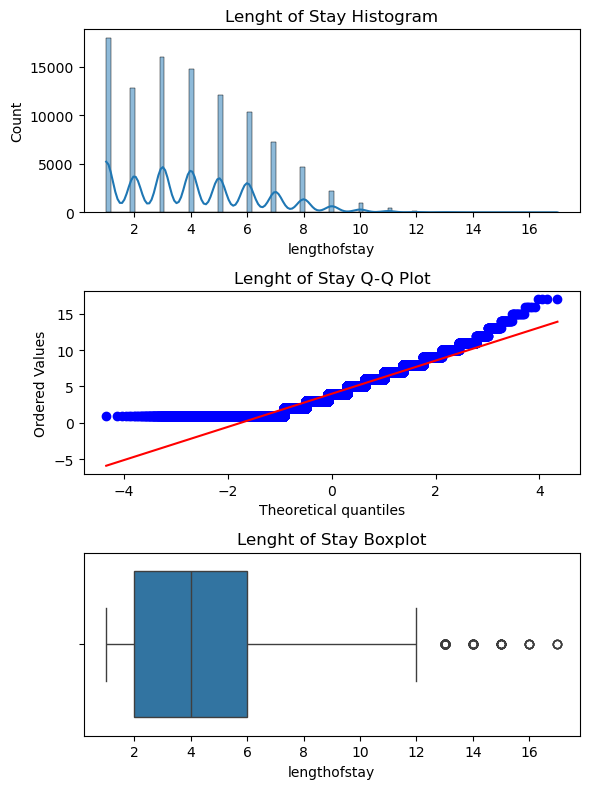

In [41]:
normality_diagnosis_plots(df['lengthofstay'], 'Lenght of Stay')

In [41]:
normaltest(df['lengthofstay'])

NormaltestResult(statistic=5582.840643791821, pvalue=0.0)

In [43]:
df['lengthofstay'].skew()

0.6282353205499585

We can be observe strong right skew. Based on the NormaltestResult, the p-value is smaller than 0.05, meaning that we reject the null hypothesis that the data is normally distributed. Let's perform log transformation to correct our target variable. 

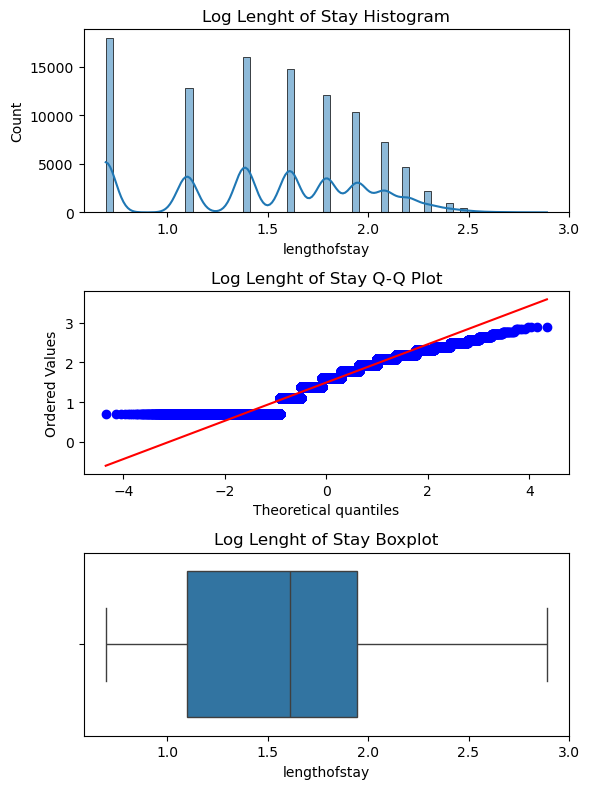

In [45]:
y_log = np.log1p(df['lengthofstay']) # np.log(y + 1)

normality_diagnosis_plots(y_log, 'Log Lenght of Stay')

In [47]:
normaltest(y_log)

NormaltestResult(statistic=19228.846161901736, pvalue=0.0)

In [49]:
y_log.skew()

-0.22110525331104894

Let's attempt to apply Box-Cox and see how it compares to log transform.

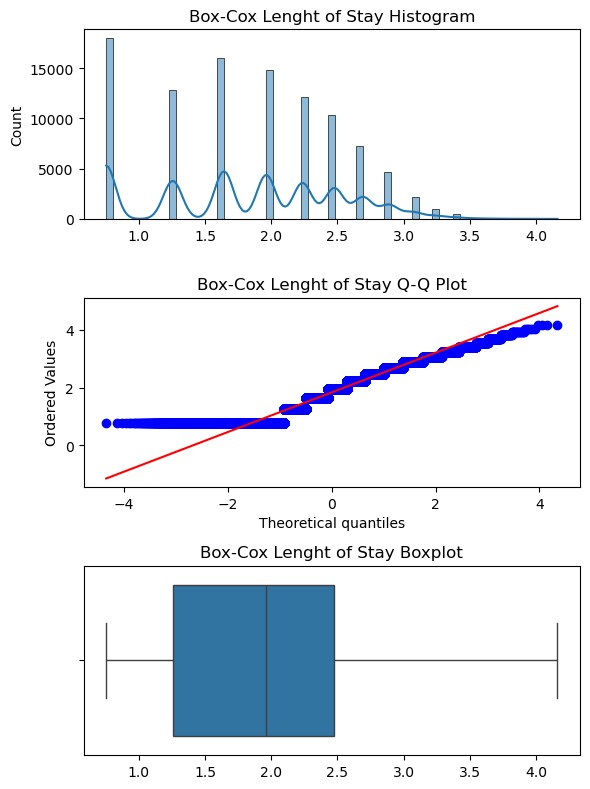

In [51]:
# First shift if zeros exist

y_positive = 1 + df['lengthofstay']

y_boxcox, lambda_bc = stats.boxcox(y_positive)

normality_diagnosis_plots(y_boxcox, 'Box-Cox Lenght of Stay')

In [53]:
normaltest(y_boxcox)

NormaltestResult(statistic=14944.630355412244, pvalue=0.0)

In [55]:
y_boxcox = pd.Series(y_boxcox, name="lengthofstay")
y_boxcox.skew()

-0.03770459118684338

We can see that after applying the transformation, that still our target variable is still not normal. But, we can observe that box-cox transformation reduce the skewness better than the log transformation. Therefore, we will use the box-cox transformaiton.

In [57]:
df['boxcox_lengthofstay'] = y_boxcox

Let's create a helper function to inverse Box-Cox transformation.

In [59]:
def inverse_boxcox(y_transformed, lmbda):
    y_inverse = np.power(lmbda * y_transformed + 1, 1 / lmbda)
    y = y_inverse - 1
    return y

## Creating Dummies

In [61]:
df['male'] = df['gender'].map({'F': 0, 'M': 1})

Let's handle the Facility ID column.

In [63]:
df = pd.get_dummies(df, columns=['facid'], dtype=int).drop(columns=["facid_E", "gender"])

In [65]:
df.dtypes.value_counts()

int64      15
float64     9
int32       6
Name: count, dtype: int64

We do not have any object dtype, we can now perform linear regression.

## Linear Regression

Let's try our original targert variable first and observe the performance of our model.

In [67]:
X = df.drop(['lengthofstay', 'boxcox_lengthofstay'], axis=1)
y = df['lengthofstay']
y_transformed = df['boxcox_lengthofstay']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_transformed_train, y_transfromed_test = y_transformed[X_train.index], y_transformed[X_test.index]

In [71]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"R^2: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

R^2: 0.766
MSE: 1.298


Let's try using the transformed version of the target variable to assess the effect of the the transformation on performance.

In [73]:
model = LinearRegression()
model.fit(X_train, y_transformed_train)
y_pred_transformed = model.predict(X_test)
print(f"R^2: {r2_score(y_transfromed_test, y_pred_transformed):.3}")

R^2: 0.727


Let's inverse the box-cox transformation.

In [75]:
y_pred_untransformed = inverse_boxcox(y_pred_transformed, lambda_bc)
print(f"R^2: {r2_score(y_test, y_pred_untransformed):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_untransformed):.3f}")

R^2: 0.692
MSE: 1.708


The r-squared score is lower for the transformed target. It means that reducing the skewness of our target variable does not offset the greater deviation from normality assumption. As such we will stick to using the untransformed version of our target variable.

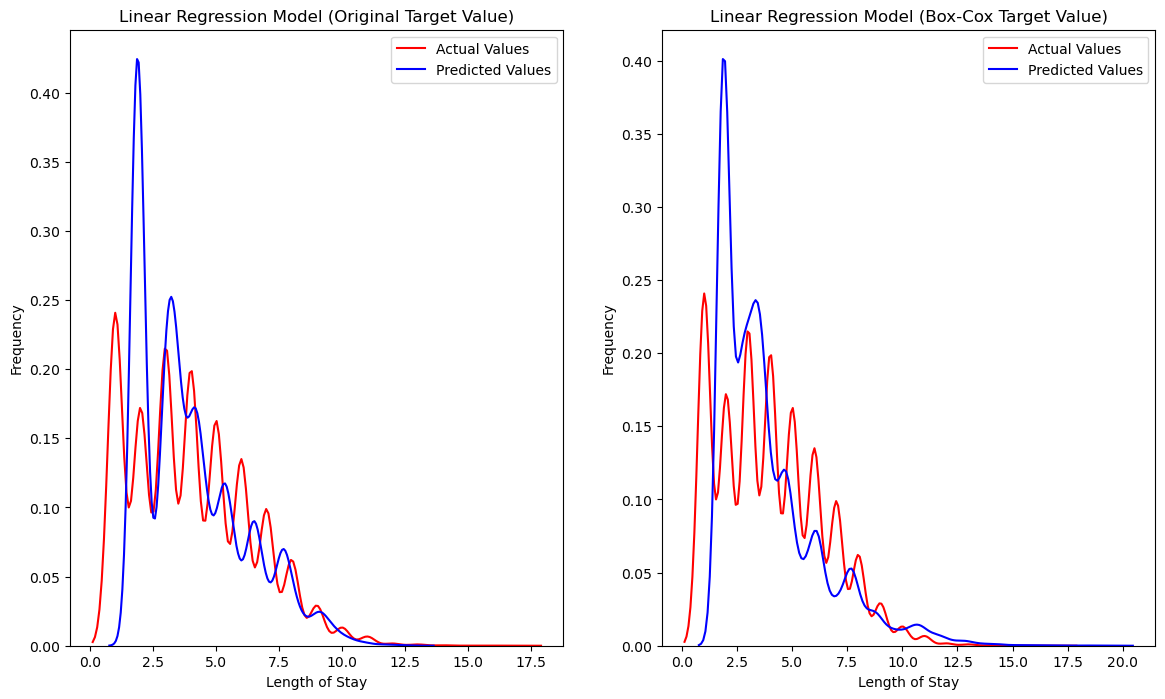

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.kdeplot(y_test, color='r', label="Actual Values", ax=axes[0])
sns.kdeplot(y_pred, color='b', label="Predicted Values", ax=axes[0])
axes[0].set_title("Linear Regression Model (Original Target Value)")
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Length of Stay")
axes[0].legend()

sns.kdeplot(y_test, color='r', label="Actual Values", ax=axes[1])
sns.kdeplot(y_pred_untransformed, color='b', label="Predicted Values", ax=axes[1])
axes[1].set_title("Linear Regression Model (Box-Cox Target Value)")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Length of Stay")
axes[1].legend()

plt.show()
plt.close()

## Polynomial Regression

We can calculate the number features after polynomial expansion using the below equation: <br>
### $ \text{Num features} = \binom{n_{features} + d}{d} - 1$

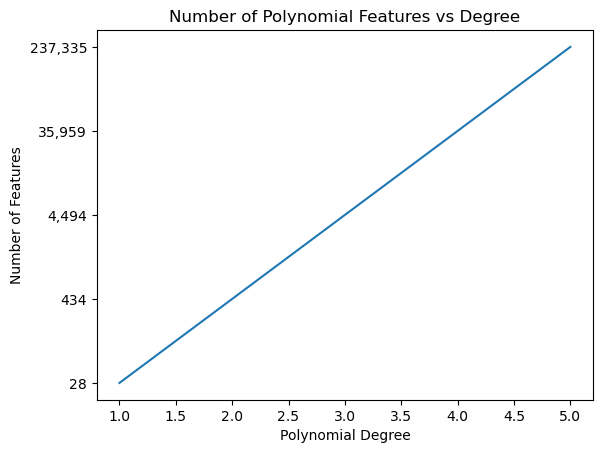

In [80]:
from math import comb

n_feat = 28

degrees = [i for i in range(1, 6)]
num_feat = [comb(n_feat + d , d) - 1 for d in degrees]

df_numFeat = pd.DataFrame({"degrees": degrees, "num_features": num_feat})
df_numFeat["num_features"] = df_numFeat["num_features"].apply(lambda x: f"{x:,}")

plt.plot(df_numFeat["degrees"], df_numFeat["num_features"])
plt.xlabel('Polynomial Degree')
plt.ylabel('Number of Features')
plt.title('Number of Polynomial Features vs Degree')
plt.show()
plt.close()

We can see that applying polynomial transformation beyond 2-degrees may not be feasible given how the number of features explodes as we increase the polynomial degree.

Here we apply 2nd order degree polynomial transformation to increase the complextiy of the model.

In [82]:
poly_feat = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.transform(X_test)

In [84]:
model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred_ploy = model.predict(X_test_poly)
print(f"R^2: {r2_score(y_test, y_pred_ploy):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ploy):.3f}")

R^2: 0.872
MSE: 0.707


When compared to original linear-model, we notice the following:
- R² increased from 0.766 → 0.872: the polynomial model explain 10% more variance in the target.
- MSE dropped from 1.298 to 0.707: The polynomial model achieves roughly 45% reduction in prediction error. <br> <br>
As such, we can conclude,
- The relationship between predictors and target is not purely linear.
- The original linear model was underfitting.

## Regularization

### LASSO

We apply standard scaling since LASSO and other regularization techniques are sensitive to feature scale.

In [86]:
pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])

alphas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 6.0]

params = {
    'lasso__alpha': alphas
}

grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=5,
    scoring={"r2": "r2", "mse": "neg_mean_squared_error"},
    refit="mse",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'lasso__alpha': [0.001, 0.002, ...]}"
,scoring,"{'mse': 'neg_mean_squared_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'mse'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [88]:
print("Best MSE Score:", round(grid_search.best_score_*-1, 4))
print("Best R^2 Score:", round(grid_search.cv_results_["mean_test_r2"].max(), 4))

Best MSE Score: 1.3397
Best R^2 Score: 0.76


In [90]:
print("Best Alpha", grid_search.best_params_)

Best Alpha {'lasso__alpha': 0.002}


Let's Check our performance on our test dataset.

In [92]:
y_pred = grid_search.predict(X_test)
print(f"R^2: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

R^2: 0.766
MSE: 1.298


The result above is simlar to the linear regression model. Let's run GridsearchCV with polynomial features of 2nd degree added. We will run the GridSearchCV on a slice of our dataset in order to save time.

In [95]:
%%time

pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)), 
    ('scaler', StandardScaler()), 
    ('lasso', Lasso(max_iter=10000))])

params = {
    'lasso__alpha': alphas
}

grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=5,
    scoring={"r2": "r2", "mse": "neg_mean_squared_error"},
    refit="mse",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train.iloc[:10000, :], y_train.iloc[:10000])

Fitting 5 folds for each of 11 candidates, totalling 55 fits
CPU times: total: 2min 38s
Wall time: 10min 23s


C:\Users\Salamh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+02, tolerance: 5.477e+00
  model = cd_fast.enet_coordinate_descent(


,estimator,Pipeline(step...iter=10000))])
,param_grid,"{'lasso__alpha': [0.001, 0.002, ...]}"
,scoring,"{'mse': 'neg_mean_squared_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'mse'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [97]:
print("Best Alpha", grid_search.best_params_)

Best Alpha {'lasso__alpha': 0.001}


Now we will refit the lasso model using the entire dataset and the optimum alpha.

In [99]:
%%time
pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)), 
    ('scaler', StandardScaler()), 
    ('lasso', Lasso(max_iter=50000, alpha=0.001))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(f"R^2: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

R^2: 0.870
MSE: 0.721
CPU times: total: 41min 52s
Wall time: 29min 48s


We observe that lasso regularization performance is about the same of that of polynomial linear regression.

### Ridge

In [101]:
%%time

ridge_alphas = np.geomspace(4, 20, 20)

pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)), 
    ('scaler', StandardScaler()), 
    ('ridge', Ridge(max_iter=10000))])

params = {
    'ridge__alpha': ridge_alphas
}

grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=5,
    scoring={"r2": "r2", "mse": "neg_mean_squared_error"},
    refit="mse",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train.iloc[:10000, :], y_train.iloc[:10000])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 1.88 s
Wall time: 27 s


,estimator,Pipeline(step...iter=10000))])
,param_grid,{'ridge__alpha': array([ 4. ... 20. ])}
,scoring,"{'mse': 'neg_mean_squared_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'mse'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [103]:
print("Best Alpha", grid_search.best_params_)

Best Alpha {'ridge__alpha': 11.053879625898109}


In [105]:
%%time
pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)), 
    ('scaler', StandardScaler()), 
    ('ridge', Ridge(max_iter=50000, alpha=11))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(f"R^2: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

R^2: 0.869
MSE: 0.726
CPU times: total: 3.08 s
Wall time: 2.64 s


We observe that both regulrization techniques do not improve the base linear model performance. 

## Model Interpretability

Let's assess model interpretability of the linear regression model with polynomial features added. This time we will scale our feature so we can compare them and observe which ones contribute more to the predictions made.

In [107]:
pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(include_bias=False, degree=2)), 
    ('scaler', StandardScaler()), 
    ('linear_reg', LinearRegression())])

pipeline.fit(X, y)

,steps,"[('polynomial', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


In [109]:
lr_coef = pipeline.named_steps["linear_reg"].coef_
feature_names = pipeline.named_steps["polynomial"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_coef
}) 

coef_df = coef_df.sort_values(by="coefficient", key=lambda x: x.abs(), ascending=False)
coef_df.head(20)

,feature,coefficient
14,sodium,-16.657352
329,sodium^2,16.529522
18,bmi,-5.648811
379,bmi^2,5.429375
19,pulse,-2.540945
20,respiration,-2.296492
389,pulse^2,2.282168
12,hematocrit,-2.159300
0,rcount,2.112038
368,creatinine^2,1.986235


In [111]:
coef_df.tail(20)

,feature,coefficient
135,pneum substancedependence,0.000923
51,rcount male,-0.000878
421,male facid_B,-0.000857
76,dialysisrenalendstage secondarydiagnosisnonicd9,-0.000803
259,fibrosisandother facid_A,0.000581
286,hemo bloodureanitro,-0.000504
410,secondarydiagnosisnonicd9 facid_B,-0.000368
166,substancedependence neutrophils,-0.000368
417,is_weekend facid_C,-0.000308
232,psychother bloodureanitro,0.000279


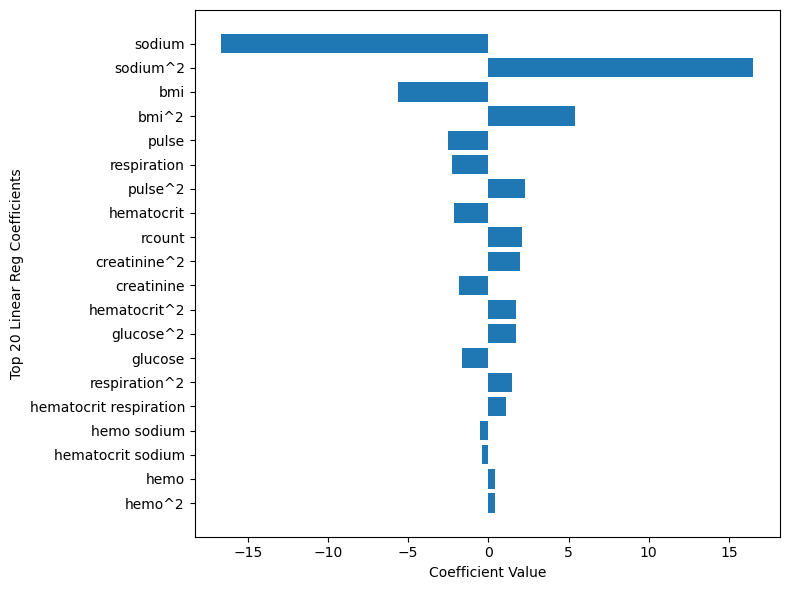

In [113]:
top_coef_df = coef_df.head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_coef_df["feature"], top_coef_df["coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Top 20 Linear Reg Coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We observe that laboratory measurements (sodium, hematocrit, creatinine, glucose), body metrics (BMI), vital signs (pulse, respiration) and their interactions are strong predictors of the hospital length of stay. Previous hospital admissions are positively associated with longer stays. Finally, the facility id has small effect on the predicted time patients spend in the hospital.